In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Conv2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
import tensorflow as tf
import matplotlib.pyplot as plt

def generate_noise(batch_size, dimension=100):
    noise = tf.random.normal([batch_size, dimension])
    return noise

def sample_dataset(dataset, batch_size):
    sample = dataset[np.random.randint(0, dataset.shape[0], size=batch_size), :, :, :]
    return sample

In [2]:
class GAN():
    def __init__(self, dataset):
        img_shape = dataset[0].shape
        self.num_examples = dataset.shape[0]
        self.dataset = dataset
        self.discriminator = self.discriminator(img_shape)
        self.generator = self.generator()

        # Tensorflow functions and optimisers
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam()
        self.discriminator_optimizer = tf.keras.optimizers.Adam()

    def discriminator(self, input_shape):
        model = tf.keras.Sequential()
        model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape))
        model.add(LeakyReLU())
        model.add(Dropout(0.3))

        model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
        model.add(LeakyReLU())
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        return model

    def generator(self):
        kernel_size = 3
        noise_shape = generate_noise(1).shape
        model = tf.keras.Sequential()
        model.add(Dense(7*7*256, use_bias=False, input_shape=(noise_shape[1],)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Reshape((7, 7, 256)))
        assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

        model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        assert model.output_shape == (None, 7, 7, 128)
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        assert model.output_shape == (None, 14, 14, 64)
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
        assert model.output_shape == (None, 28, 28, 1)

        model.summary()

        return model

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def train_step(self, images, batch_size):
        noise = generate_noise(batch_size)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                                     self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                                         self.discriminator.trainable_variables))

        return gen_loss.numpy(), disc_loss.numpy(), generated_images

    def train(self, batch_size=512, epoch=50):
        steps = self.num_examples // batch_size

        for i in range(epoch):
            for j in range(steps):
                training_images = sample_dataset(self.dataset, batch_size)
                gen_loss, disc_loss, generated_images = self.train_step(training_images, batch_size)
            print('Losses at Epoch ', str(i), ' / ',  epoch, ' : ', 'G: ', gen_loss, 'D:', disc_loss)
            self.visualise_training(generated_images, i)

    def visualise_training(self, generated_image, epoch):
        fig = plt.figure(figsize=(4,4))

        for i in range(16):
            plt.subplot(4,4, i+1)
            img = generated_image.numpy()
            img = np.reshape(img[i], (img[i].shape[0], img[i].shape[1]))
            img = img * 127.5 + 127.5
            plt.imshow(img, cmap='gray')
            plt.axis('off')

        plt.savefig('output{:04d}.png'.format(epoch))
        plt.show()

In [3]:
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Reshape data
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)).astype('float32')
x_train = (x_train - 127.5) / 127.5

num_examples = x_train.shape[0]

gan = GAN(x_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

Losses at Epoch  0  /  50  :  G:  6.53242 D: 0.97832084


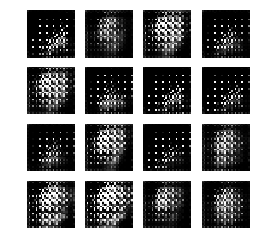

Losses at Epoch  1  /  50  :  G:  4.253911 D: 1.3490219


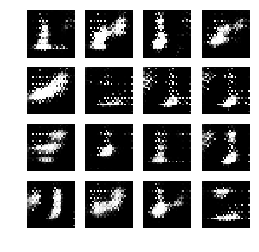

Losses at Epoch  2  /  50  :  G:  5.809175 D: 0.31929934


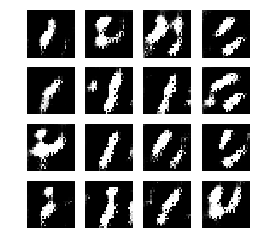

Losses at Epoch  3  /  50  :  G:  4.752085 D: 0.40432966


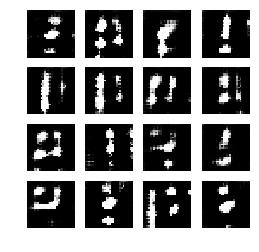

Losses at Epoch  4  /  50  :  G:  3.510323 D: 0.6089392


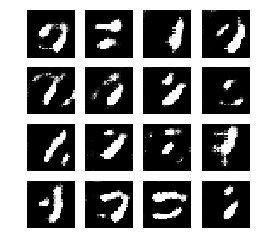

Losses at Epoch  5  /  50  :  G:  3.2996747 D: 0.46589


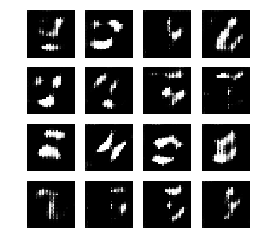

Losses at Epoch  6  /  50  :  G:  3.684109 D: 0.43150437


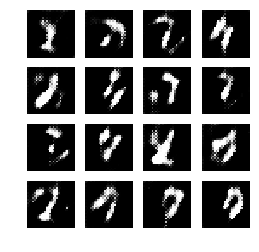

Losses at Epoch  7  /  50  :  G:  3.459571 D: 1.0198345


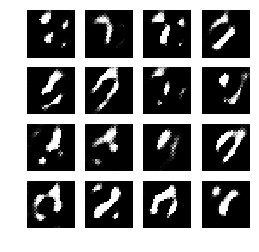

Losses at Epoch  8  /  50  :  G:  2.8050747 D: 0.5756761


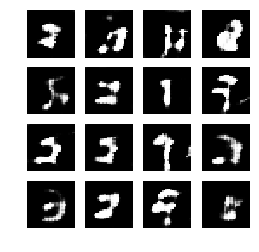

Losses at Epoch  9  /  50  :  G:  2.6141768 D: 0.4977217


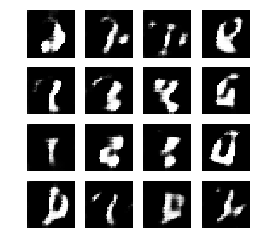

Losses at Epoch  10  /  50  :  G:  2.1662445 D: 0.8016052


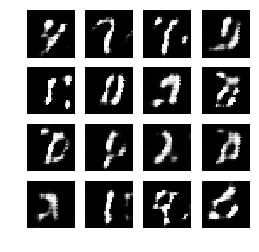

In [ ]:
gan.train()